# Modeling Phase

### Load Python modules

In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

plt.style.use('ggplot')

In [57]:
dt_cleaned = pd.read_csv('dt_cleaned.csv', sep=',')
dt_cleaned

,age_cat,ethnicity,is_recid,score_text,sex
0,senior,Other,0,Low,Male
1,adult,African-American,1,Low,Male
2,young,African-American,1,Low,Male
3,young,African-American,0,High,Male
4,adult,Other,0,Low,Male
...,...,...,...,...,...
11022,senior,Other,0,Low,Male
11023,young,Caucasian,1,Medium,Male
11024,adult,Other,0,Low,Male
11025,adult,Caucasian,0,Low,Male


In [58]:
dt_date_r = pd.read_csv('dt_date_r.csv', sep=',')
dt_date_r

,age_cat,dates_diff_in_days,ethnicity,score_text,sex
0,adult,160,African-American,Low,Male
1,young,64,African-American,Low,Male
2,adult,41,Caucasian,Medium,Male
3,young,736,Caucasian,Low,Male
4,young,128,African-American,Medium,Male
...,...,...,...,...,...
3088,senior,286,African-American,Medium,Male
3089,young,296,Caucasian,Low,Female
3090,young,9,African-American,Low,Male
3091,senior,30,African-American,Low,Male


### Check Attribute types

In [59]:
dt_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11027 entries, 0 to 11026
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age_cat     11027 non-null  object
 1   ethnicity   11027 non-null  object
 2   is_recid    11027 non-null  int64 
 3   score_text  11027 non-null  object
 4   sex         11027 non-null  object
dtypes: int64(1), object(4)
memory usage: 430.9+ KB


In [60]:
dt_cleaned['age_cat'] = dt_cleaned['age_cat'].astype('category')
dt_cleaned['ethnicity'] = dt_cleaned['ethnicity'].astype('category')
dt_cleaned['score_text'] = dt_cleaned['score_text'].astype('category')
dt_cleaned['sex'] = dt_cleaned['sex'].astype('category')
dt_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11027 entries, 0 to 11026
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age_cat     11027 non-null  category
 1   ethnicity   11027 non-null  category
 2   is_recid    11027 non-null  int64   
 3   score_text  11027 non-null  category
 4   sex         11027 non-null  category
dtypes: category(4), int64(1)
memory usage: 129.9 KB


#### Add dummies instead of categorical attributes

In [61]:
number = preprocessing.LabelEncoder()
for attribute in dt_cleaned.columns:
    if dt_cleaned[attribute].dtype.name == "category":
        dt_cleaned[attribute] = number.fit_transform(dt_cleaned[attribute])

### Check if the dataset is balanced

In [62]:
dt_cleaned['is_recid'].value_counts()

0    7326
1    3701
Name: is_recid, dtype: int64

Resample Algorithm is needed.

### Split Dataset into Training Set and Test Set

In [63]:
X = dt_cleaned.drop('is_recid', axis=1)
y = dt_cleaned['is_recid']

seed = 121
test_size= 0.25
# 75% train set, 25% test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

training_set = pd.concat([X_train, y_train], axis=1)
recid = training_set[training_set.is_recid==1]
not_recid = training_set[training_set.is_recid==0]

In [64]:
recid.shape

(2776, 5)

In [65]:
not_recid.shape

(5494, 5)

#### Perform Undersampling

In [66]:
from sklearn.utils import resample

In [67]:
not_recid_resampled = resample(not_recid, replace = True, n_samples=int(len(recid)), random_state=seed) #n_samples=int(len(recid)*1.3

dt_resampled = pd.concat([recid, not_recid_resampled])

X_train = dt_resampled.drop("is_recid", axis=1)
y_train = dt_resampled['is_recid']

In [68]:
dt_resampled.is_recid.value_counts()

1    2776
0    2776
Name: is_recid, dtype: int64

#### Build different models and evaluate them using three metrics: *accuracy*, *recall* and *precision*

In [69]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

#### Find the best parameters

##### Decision Tree

In [70]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion':  ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_leaf_nodes': [None, 5, 10, 15],
    'random_state': [None, 1, 2, 3, 4, 5]
}

clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 15, 'random_state': None, 'splitter': 'random'}


In [71]:
knn_params = {
    'n_neighbors':  [1, 2, 3, 4, 5]
}

knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

knn.fit(X_train, y_train)
print(knn.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_neighbors': 2}


In [72]:
rf_params = {
    'random_state':  [10, 20, 30, 40, 50]
}

rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

rf.fit(X_train, y_train)
print(rf.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'random_state': 30}


In [73]:
ab_params = {
    'random_state':  [110, 120, 130, 140, 150]
}

ab = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=ab_params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

ab.fit(X_train, y_train)
print(ab.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'random_state': 110}


In [74]:
models = []

models.append(("Naive Bayes", GaussianNB()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier(criterion="gini", splitter="random", random_state=5, max_depth=None, max_leaf_nodes=15)))
models.append(("KNeighborsClassifier", KNeighborsClassifier(2)))
models.append(("Random Forest", RandomForestClassifier(random_state=30)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=110)))

for name, model in models:
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  print(f'{name}:\n')
  print(f'Accuracy: {metrics.accuracy_score(y_test, predictions):.4f}')
  print(f'Recall: {metrics.recall_score(y_test, predictions):.4f}')
  print(f'Precision: {metrics.precision_score(y_test, predictions):.4f}')
  print(f'F-measure: {metrics.f1_score(y_test, predictions):.4f}\n')

Naive Bayes:

Accuracy: 0.5934
Recall: 0.6670
Precision: 0.4315
F-measure: 0.5240

DecisionTreeClassifier:

Accuracy: 0.6402
Recall: 0.5816
Precision: 0.4707
F-measure: 0.5203

KNeighborsClassifier:

Accuracy: 0.3442
Recall: 0.9903
Precision: 0.3374
F-measure: 0.5033

Random Forest:

Accuracy: 0.6380
Recall: 0.6151
Precision: 0.4699
F-measure: 0.5328

AdaBoost:

Accuracy: 0.6369
Recall: 0.5838
Precision: 0.4671
F-measure: 0.5190



### Evaluation - Random Forest

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [47]:
model = RandomForestClassifier(random_state=30)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')

Accuracy: 0.64


In [48]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sn.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

#### Confusion Matrix

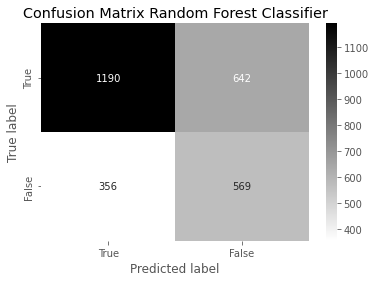

In [49]:
categories = ['True', 'False']
make_confusion_matrix(confusion_matrix(y_test, predictions), categories=categories, cmap='binary', title='Confusion Matrix Random Forest Classifier')

#### Classification Report

In [50]:
print("Classification Report - Random Forest Classifier")
print(metrics.classification_report(y_test, predictions))

Classification Report - Random Forest Classifier
              precision    recall  f1-score   support

           0       0.77      0.65      0.70      1832
           1       0.47      0.62      0.53       925

    accuracy                           0.64      2757
   macro avg       0.62      0.63      0.62      2757
weighted avg       0.67      0.64      0.65      2757



#### ROC Curve

In [51]:
from sklearn.metrics import roc_curve, auc

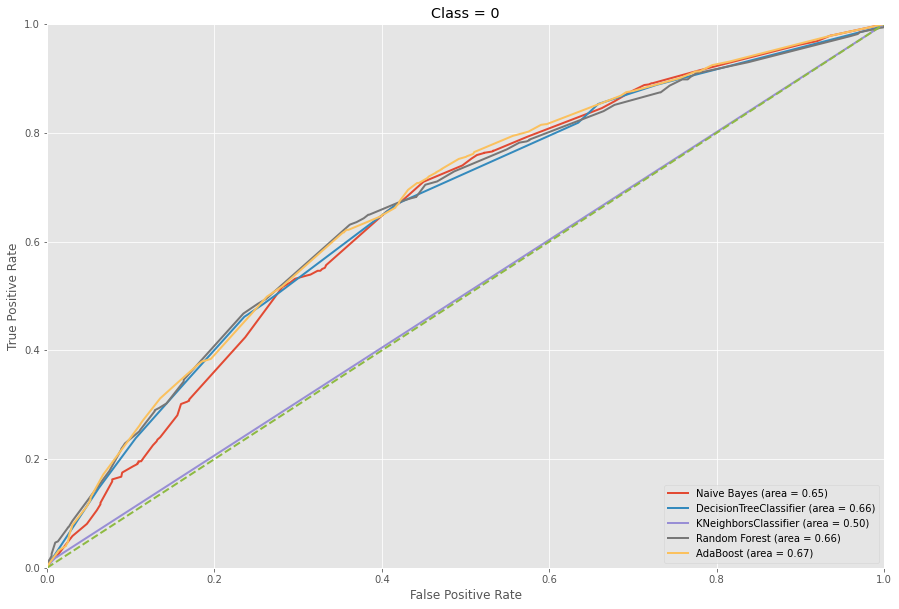

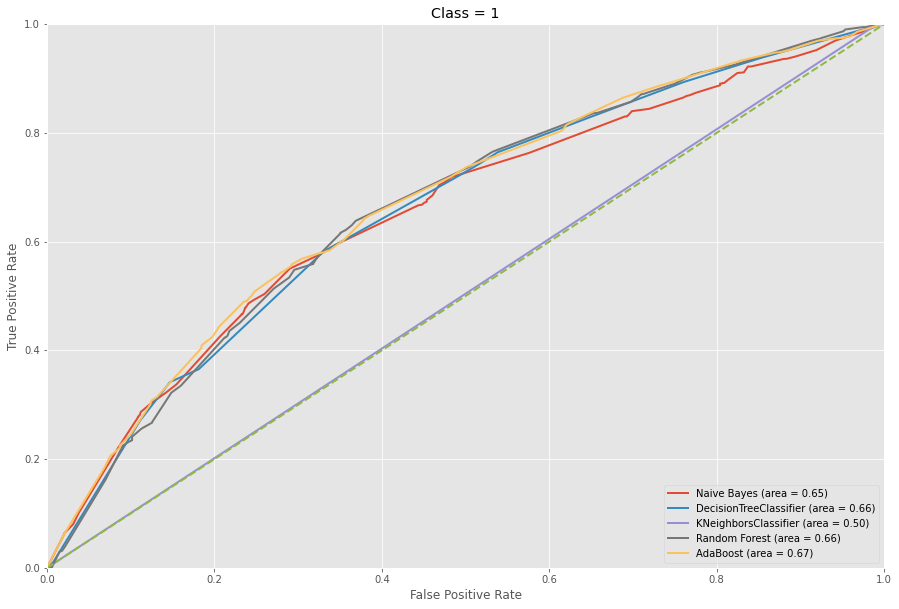

In [52]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['is_recid']))

probs = []

for _, model in models:
    model.fit(X_train, y_train)
    probs.append(model.predict_proba(X_test))
    
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure(figsize=(15,10))
    m = 0

    for name, _ in models:
        fpr[i], tpr[i], _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2, label=name + f' (area = {roc_auc[i]:.2f})')
        m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y)[i]))
    plt.legend(loc='lower right')

    plt.show()

Comparison between Random Forest and AdaBoost

In [53]:
model = AdaBoostClassifier(random_state=110)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')

Accuracy: 0.64


Classification Report

In [54]:
print("Classification Report - Ada Boost Classifier")
print(metrics.classification_report(y_test, predictions))

Classification Report - Ada Boost Classifier
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1832
           1       0.47      0.58      0.52       925

    accuracy                           0.64      2757
   macro avg       0.61      0.62      0.61      2757
weighted avg       0.66      0.64      0.64      2757



We noticed that, although the AUC is higher for AdaBoost classifier, if we look at the F1-measure value, the best model for Classification equal to 1 (ndr recidivist) is Random Forest.